# Model Comparison: Bayes Classifier vs Custom CNN

This notebook compares two approaches for waste classification:
- **Bayes Classifier**: Feature-based statistical classifier
- **Custom CNN**: Deep learning model trained from scratch

## 1. Setup

In [7]:
import sys
sys.path.append('..')

import torch
import torch_directml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

from src.config import load_config
from src.load_data import load_data, TrashNetDataset
from src.transforms import get_transforms
from src.models.bayes import BayesClassifier
from src.models.cnn import create_custom_cnn
from src.evaluation import load_model_checkpoint, evaluate_model
from torch.utils.data import DataLoader

config = load_config()
device = torch_directml.device()

print(f"Device: {device}")
print(f"Dataset: {config['data']['dataset_name']}")
print(f"Classes: {config['data']['classes']}")

Device: privateuseone:0
Dataset: garythung/trashnet
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## 2. Load Test Data

In [9]:
# Load test dataset
_, _, test_hf = load_data(split_data=True)
print(f"Test samples: {len(test_hf)}")

# Create dataloader for CNN
val_transform = get_transforms(config, split='val')
test_dataset = TrashNetDataset(test_hf, transform=val_transform)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,           # smaller to reduce initial GPU load
    shuffle=False,
    num_workers=0,          # avoid worker spawn overhead on Windows
    pin_memory=False,       # skip pinning; DML sometimes behaves better without it
    persistent_workers=False
)


Test samples: 759


## 3. Load Models

In [10]:
# Load Bayes Classifier
bayes_path = Path(config['paths']['models_dir']) / 'bayes_classifier.pkl'
bayes_classifier = BayesClassifier.load(bayes_path)
print(f"Loaded Bayes from: {bayes_path}")

# Load Custom CNN
cnn_model = create_custom_cnn(num_classes=config['data']['num_classes'])
cnn_path = Path(config['paths']['models_dir']) / 'custom_cnn_best.pth'
cnn_model = load_model_checkpoint(cnn_model, cnn_path, device=device)
cnn_model.eval()
print(f"Loaded CNN from: {cnn_path}")

Model loaded from models\bayes_classifier.pkl
Loaded Bayes from: models\bayes_classifier.pkl

[Model] Creating Custom CNN...
  Architecture: 4 Conv blocks (32->64->128->256)
  Dropout: 0.5
  Output classes: 6
  [Model] Custom CNN created
  [Model] Total parameters: 1,207,846
  [Model] Trainable parameters: 1,207,846
  [Model] Model size: ~4.61 MB

  [Model] Architecture Summary:
    Input: 3x224x224
    Conv Block 1: 32 channels -> 112x112
    Conv Block 2: 64 channels -> 56x56
    Conv Block 3: 128 channels -> 28x28
    Conv Block 4: 256 channels -> 14x14
    Global Avg Pool: 256x1x1
    FC: 256 -> 128 -> 6
Loaded checkpoint from models\custom_cnn_best.pth
  Epoch: 31
  Val Acc: 65.83%
  Val Loss: 0.9400
Loaded CNN from: models\custom_cnn_best.pth


c:\Users\kkuli\BayesCNN-Waste\notebooks\..\src\evaluation.py:199: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location='cpu')


## 4. Evaluate Bayes Classifier

In [11]:
bayes_start = time.time()
bayes_results = bayes_classifier.evaluate(test_hf, verbose=True)
bayes_time = time.time() - bayes_start

bayes_preds = bayes_results['predictions']
bayes_labels = bayes_results['true_labels']
bayes_acc = bayes_results['accuracy']
bayes_cm = bayes_results['confusion_matrix']

Extracting features for evaluation: 100%|██████████| 759/759 [02:09<00:00,  5.87it/s]


Evaluation Results
Accuracy:  0.5995
Precision: 0.6253
Recall:    0.5995
F1 Score:  0.6091

Per-class metrics:
Class        |  Precision |     Recall |         F1 |  Support
-------------+------------+------------+------------+---------
cardboard    |     0.8557 |     0.7155 |     0.7793 |      116
glass        |     0.5120 |     0.5519 |     0.5312 |      154
metal        |     0.4833 |     0.4874 |     0.4854 |      119
paper        |     0.7198 |     0.7278 |     0.7238 |      180
plastic      |     0.6720 |     0.5563 |     0.6087 |      151
trash        |     0.2029 |     0.3590 |     0.2593 |       39


## 5. Evaluate Custom CNN

In [12]:
cnn_start = time.time()
cnn_acc, cnn_preds, cnn_labels, cnn_cm = evaluate_model(
    cnn_model, test_loader, device, model_name='Custom CNN'
)
cnn_time = time.time() - cnn_start

print(f"CNN Eval Time: {cnn_time:.2f}s")

Testing Custom CNN:   0%|          | 0/95 [00:00<?, ?it/s]


Custom CNN Test Accuracy: 60.87% (462/759)
CNN Eval Time: 174.81s


## 6. Metrics Comparison

In [13]:
# Overall metrics
total = len(cnn_labels)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy (%)', 'Eval Time (s)', 'Throughput (samples/s)', 'Time per Image (ms)'],
    'Bayes': [
        f"{bayes_acc*100:.2f}",
        f"{bayes_time:.2f}",
        f"{len(test_hf)/bayes_time:.2f}",
        f"{bayes_time/len(test_hf)*1000:.2f}"
    ],
    'CNN': [
        f"{cnn_acc:.2f}",
        f"{cnn_time:.2f}",
        f"{total/cnn_time:.2f}",
        f"{cnn_time/total*1000:.2f}"
    ]
})

print("\n" + "="*60)
print("PERFORMANCE METRICS")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)


PERFORMANCE METRICS
                Metric  Bayes    CNN
          Accuracy (%)  59.95  60.87
         Eval Time (s) 129.31 174.81
Throughput (samples/s)   5.87   4.34
   Time per Image (ms) 170.37 230.32


## 7. Per-Class Accuracy

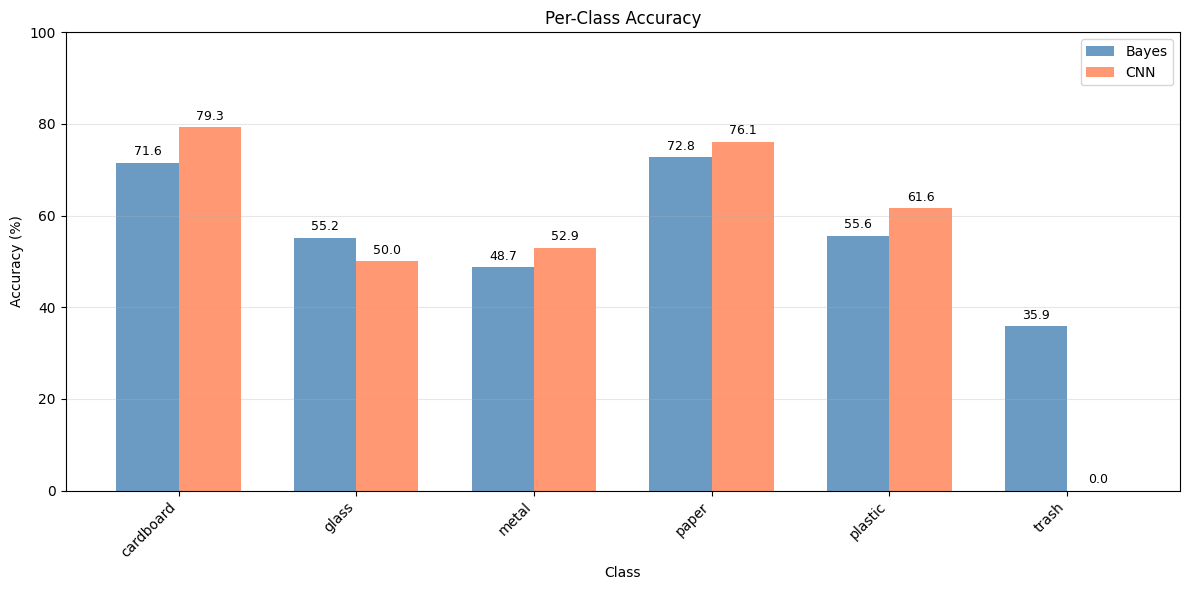


PER-CLASS ACCURACY (%)
Class             Bayes        CNN       Diff
------------------------------------------------------------
cardboard         71.55      79.31      +7.76
glass             55.19      50.00      -5.19
metal             48.74      52.94      +4.20
paper             72.78      76.11      +3.33
plastic           55.63      61.59      +5.96
trash             35.90       0.00     -35.90


In [14]:
class_names = config['data']['classes']
num_classes = len(class_names)

bayes_class_acc = [100 * bayes_cm[i, i] / bayes_cm[i].sum() for i in range(num_classes)]
cnn_class_acc = [100 * cnn_cm[i, i] / cnn_cm[i].sum() for i in range(num_classes)]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_classes)
width = 0.35

ax.bar(x - width/2, bayes_class_acc, width, label='Bayes', color='steelblue', alpha=0.8)
ax.bar(x + width/2, cnn_class_acc, width, label='CNN', color='coral', alpha=0.8)

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Class')
ax.set_title('Per-Class Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 100])

for i, (b, c) in enumerate(zip(bayes_class_acc, cnn_class_acc)):
    ax.text(i - width/2, b + 1, f'{b:.1f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, c + 1, f'{c:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(Path(config['paths']['results_dir']) / 'per_class_accuracy.png', dpi=150)
plt.show()

# Table
print("\n" + "="*60)
print("PER-CLASS ACCURACY (%)")
print("="*60)
print(f"{'Class':<12} {'Bayes':>10} {'CNN':>10} {'Diff':>10}")
print("-"*60)
for i, name in enumerate(class_names):
    diff = cnn_class_acc[i] - bayes_class_acc[i]
    print(f"{name:<12} {bayes_class_acc[i]:>10.2f} {cnn_class_acc[i]:>10.2f} {diff:>+10.2f}")
print("="*60)

## 8. Confusion Matrices

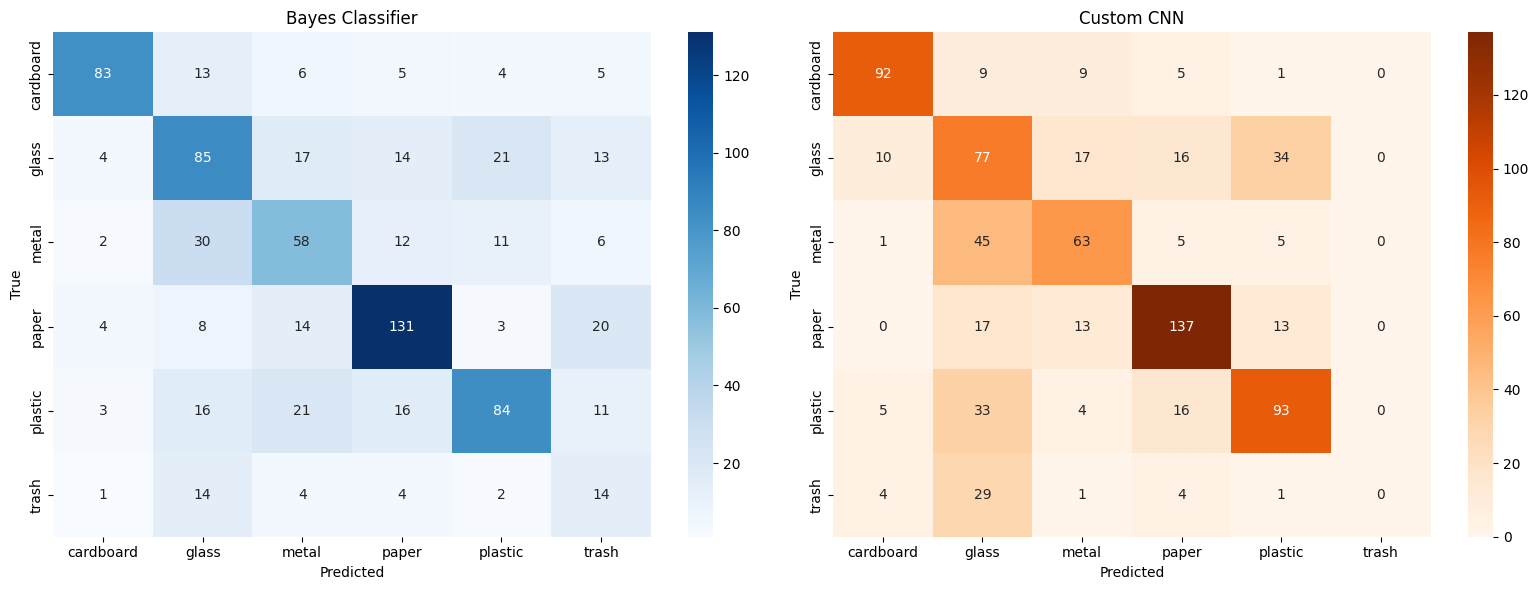

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(bayes_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title(f'Bayes Classifier')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title(f'Custom CNN')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig(Path(config['paths']['results_dir']) / 'confusion_matrices.png', dpi=150)
plt.show()

## 9. Classification Reports

In [16]:
print("\n" + "="*60)
print("BAYES CLASSIFIER")
print("="*60)
print(classification_report(bayes_labels, bayes_preds, target_names=class_names, digits=4))

print("\n" + "="*60)
print("CUSTOM CNN")
print("="*60)
print(classification_report(cnn_labels, cnn_preds, target_names=class_names, digits=4))


BAYES CLASSIFIER
              precision    recall  f1-score   support

   cardboard     0.8557    0.7155    0.7793       116
       glass     0.5120    0.5519    0.5312       154
       metal     0.4833    0.4874    0.4854       119
       paper     0.7198    0.7278    0.7238       180
     plastic     0.6720    0.5563    0.6087       151
       trash     0.2029    0.3590    0.2593        39

    accuracy                         0.5995       759
   macro avg     0.5743    0.5663    0.5646       759
weighted avg     0.6253    0.5995    0.6091       759


CUSTOM CNN
              precision    recall  f1-score   support

   cardboard     0.8214    0.7931    0.8070       116
       glass     0.3667    0.5000    0.4231       154
       metal     0.5888    0.5294    0.5575       119
       paper     0.7486    0.7611    0.7548       180
     plastic     0.6327    0.6159    0.6242       151
       trash     0.0000    0.0000    0.0000        39

    accuracy                         0.6087    

c:\Users\kkuli\miniconda3\envs\bayescnn-directml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kkuli\miniconda3\envs\bayescnn-directml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kkuli\miniconda3\envs\bayescnn-directml\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

## 10. Model Agreement


MODEL AGREEMENT
Both correct:     351 ( 46.2%)
Both wrong:       193 ( 25.4%)
Only Bayes:       104 ( 13.7%)
Only CNN:         111 ( 14.6%)


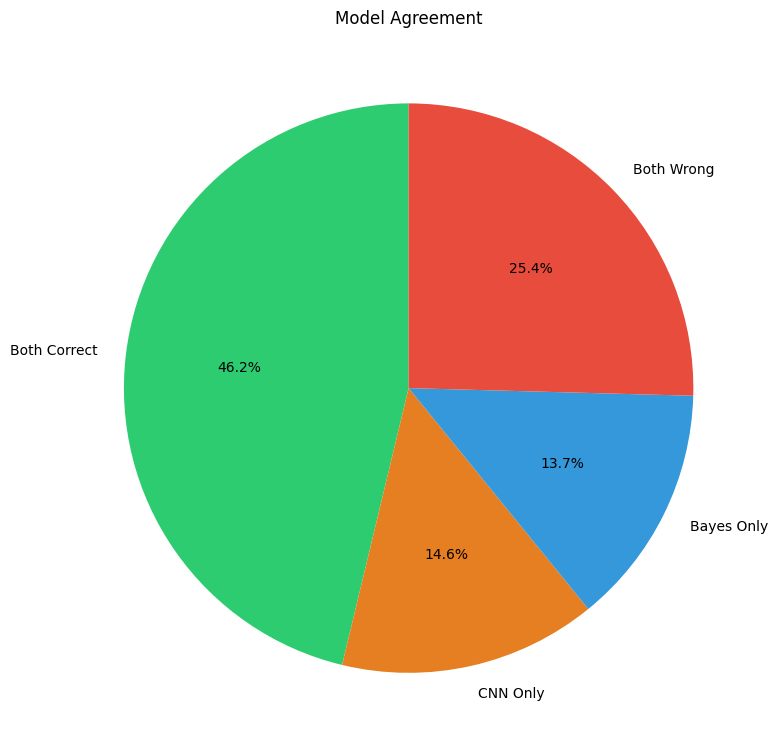

In [17]:
both_correct = (bayes_preds == bayes_labels) & (cnn_preds == cnn_labels)
both_wrong = (bayes_preds != bayes_labels) & (cnn_preds != cnn_labels)
bayes_only = (bayes_preds == bayes_labels) & (cnn_preds != cnn_labels)
cnn_only = (bayes_preds != bayes_labels) & (cnn_preds == cnn_labels)

print("\n" + "="*60)
print("MODEL AGREEMENT")
print("="*60)
print(f"Both correct:    {both_correct.sum():>4} ({100*both_correct.sum()/len(test_hf):>5.1f}%)")
print(f"Both wrong:      {both_wrong.sum():>4} ({100*both_wrong.sum()/len(test_hf):>5.1f}%)")
print(f"Only Bayes:      {bayes_only.sum():>4} ({100*bayes_only.sum()/len(test_hf):>5.1f}%)")
print(f"Only CNN:        {cnn_only.sum():>4} ({100*cnn_only.sum()/len(test_hf):>5.1f}%)")
print("="*60)

# Pie chart
fig, ax = plt.subplots(figsize=(8, 8))
data = [both_correct.sum(), cnn_only.sum(), bayes_only.sum(), both_wrong.sum()]
labels = ['Both Correct', 'CNN Only', 'Bayes Only', 'Both Wrong']
colors = ['#2ecc71', '#e67e22', '#3498db', '#e74c3c']

ax.pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Model Agreement')
plt.tight_layout()
plt.savefig(Path(config['paths']['results_dir']) / 'agreement.png', dpi=150)
plt.show()

## 11. Model Complexity

In [18]:
bayes_size_kb = bayes_path.stat().st_size / 1024
cnn_size_mb = cnn_path.stat().st_size / (1024 * 1024)
cnn_params = sum(p.numel() for p in cnn_model.parameters())

print("\n" + "="*60)
print("MODEL COMPLEXITY")
print("="*60)
print(f"{'Metric':<25} {'Bayes':<15} {'CNN':<15}")
print("-"*60)
print(f"{'Size':<25} {f'{bayes_size_kb:.1f} KB':<15} {f'{cnn_size_mb:.1f} MB':<15}")
print(f"{'Parameters':<25} {'~1,000':<15} {f'{cnn_params:,}':<15}")
print("="*60)


MODEL COMPLEXITY
Metric                    Bayes           CNN            
------------------------------------------------------------
Size                      9.5 KB          20.1 MB        
Parameters                ~1,000          1,207,846      


## 12. Save Results

In [ ]:
import json

results = {
    'bayes': {
        'accuracy': float(bayes_acc),
        'eval_time_s': float(bayes_time),
        'throughput': float(len(test_hf)/bayes_time),
        'size_kb': float(bayes_size_kb),
        'per_class': {class_names[i]: float(bayes_class_acc[i]) for i in range(num_classes)},
        'confusion_matrix': bayes_cm.tolist()
    },
    'cnn': {
        'accuracy': float(cnn_acc),
        'eval_time_s': float(cnn_time),
        'throughput': float(total/cnn_time),
        'size_mb': float(cnn_size_mb),
        'parameters': int(cnn_params),
        'per_class': {class_names[i]: float(cnn_class_acc[i]) for i in range(num_classes)},
        'confusion_matrix': cnn_cm.tolist()
    },
    'agreement': {
        'both_correct': int(both_correct.sum()),
        'both_wrong': int(both_wrong.sum()),
        'bayes_only': int(bayes_only.sum()),
        'cnn_only': int(cnn_only.sum())
    }
}

save_path = Path(config['paths']['results_dir']) / 'comparison_results.json'
with open(save_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {save_path}")